# Writing the pair momentum distribution in terms of single-nucleon momentum distributions

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ July 4, 2023

We compute pair momentum distributions in terms of single-nucleon momentum distributions.

_Last update:_ August 23, 2023

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import InterpolatedUnivariateSpline

In [2]:
# Imports from scripts
from scripts.figures import set_rc_parameters, label_lambda, label_nucleus
from scripts.integration import gaussian_quadrature_mesh

from test_momentum_distribution_script import load_momentum_distribution
from test_pmd_script import load_pmd

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
vmc_directory = '../data/vmc/momentum_distributions/'

## Testing

$$
n_{pn}(q, Q) \approx \frac{1}{2} (4\pi)^2 \int_{-1}^1 \frac{dx}{2}\,
    n_n(\lvert \frac{\mathbf{Q}}{2}-\mathbf{q} \rvert)\,
    n_p(\lvert \frac{\mathbf{Q}}{2}+\mathbf{q} \rvert)
$$
where</br>
$$
\lvert \frac{\mathbf{Q}}{2}\pm\mathbf{q} \rvert = \sqrt{\frac{Q^2}{4}+q^2 \pm qQx}
$$

In [5]:
# n(q, Q) = < Phi | dU a^t a^t a a a^t a^t a a a^t a^t a a dU^t | \Phi >
# dU(k,q) dU^\dagger(q,k') psi(k1) psi(k2) psi(k3) psi(k4)
# where k_i = Q/2+-k


# a^t a^t a a = a^t a + 1/2 a^t a a^t a
# = ... + 1/2 U a^t a U^t U a^t a U^t
# = ... + 1/2 < Phi | U a^t a U^t U a^t a U^t | Phi >
# = ... + 1/2 SUM < Phi | U a^t a U^t | Psi > < Psi | U a^t a U^t | Phi >
# \approx ... + 1/2 < Phi | U a^t a U^t | Phi > < Phi | U a^t a U^t | Phi >

In [6]:
def n_pair(
        nucleus_name, pair, kvnn, lamb, Q_max=5.0, ntot_Q=50,
        print_normalization=False
):
    """Pair momentum distribution in terms of single-nucleon momentum
    distributions.
    """
    
    if pair == 'pp':
        nucleon = 'proton'
        nucleonp = 'proton'
    elif pair == 'nn':
        nucleon = 'neutron'
        nucleonp = 'neutron'
    elif pair == 'pn':
        nucleon = 'proton'
        nucleonp = 'neutron'
    elif pair == 'np':
        nucleon = 'neutron'
        nucleonp = 'proton'

#     # C.o.M. momenta
#     Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Load single-nucleon momentum distributions
    (q_array, q_weights, n_tau_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleon, kvnn, lamb)
    )
    (q_array, q_weights, n_taup_array, _, _, _, _, _, _) = (
        load_momentum_distribution(nucleus_name, nucleonp, kvnn, lamb)
    )
    
    # TESTING
    Q_array, Q_weights = q_array, q_weights
    
    # Interpolate single-nucleon momentum distributions
    n_tau_func = InterpolatedUnivariateSpline(q_array, n_tau_array)
    n_taup_func = InterpolatedUnivariateSpline(q_array, n_taup_array)
    
    # Integration for angle between q_vector and Q_vector
    x_array, x_weights = leggauss(29)
    
    # Get 3-D meshgrid and integrate evaluate n(q_vector, Q_vector)
    q_grid, Q_grid, x_grid = np.meshgrid(q_array, Q_array, x_array,
                                         indexing='ij')
    _, _, dx_grid = np.meshgrid(q_array, Q_array, x_weights, indexing='ij')
    
    # |Q/2+q|
    q1_grid = np.sqrt(Q_grid ** 2 / 4 + q_grid ** 2 + q_grid * Q_grid * x_grid)
    q2_grid = np.sqrt(Q_grid ** 2 / 4 + q_grid ** 2 - q_grid * Q_grid * x_grid)
    
#     # n^\tau(|Q/2+q|)
#     n_tau_grid_x = n_tau_func(q1_grid)
#     # n^\tau'(|Q/2-q|)
#     n_taup_grid_x = n_taup_func(q2_grid)
    # n^\tau(|Q/2+q|) * n^\tau'(|Q/2-q|)
    integrand_x = 1/2 * n_tau_func(q1_grid) * n_taup_func(q2_grid)
    
    # Average over x
#     n_tau_grid = np.sum(n_tau_grid_x * dx_grid, axis=-1) / 2
#     n_taup_grid = np.sum(n_taup_grid_x * dx_grid, axis=-1) / 2
    n_grid = 4 * np.pi * np.sum(integrand_x * dx_grid, axis=-1) / 2
    
    # Append q=0 term?
    if pair == 'pp' or pair == 'nn':
        # TO-DO!
        pass
    
#     # 1/2 n^\tau'(q,Q) n^\tau(q,Q)
#     n_grid = 1/2 * n_tau_grid * n_taup_grid
    
    if print_normalization:
        
        q_grid, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
        dq_grid, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
        jacobian = 4 * np.pi * q_grid ** 2 * dq_grid * Q_grid ** 2 * dQ_grid
        
        normalization = np.sum(np.sum(jacobian * n_grid, axis=-1), axis=-1)
        print(f"Normalization = {normalization:.5f}.")
    
    return q_array, q_weights, Q_array, Q_weights, n_grid

In [7]:
def pair_momentum_distribution_q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e4),
        y_scale='log', show_vmc=False
):
    """Plot a pair momentum distribution w.r.t. q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair.txt"
        data = np.loadtxt(vmc_directory + file_name)
        q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        if y_scale == 'linear':
            
            ax.errorbar(
                q_array_vmc, n_array_vmc * q_array_vmc ** 2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
            
        else:
            
            ax.errorbar(
                q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )
            
    # Load data from file
    (q_array, q_weights, Q_array, Q_weights, n_pair_grid, _, _, _, _, _, _) = (
        load_pmd(nucleus_name, pair, kvnn, lamb))
    # Integrate out Q dependence
    _, Q_grid = np.meshgrid(q_array, Q_array, indexing='ij')
    _, dQ_grid = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_grid ** 2 * dQ_grid
    n_pair_array = np.sum(jacobian * n_pair_grid, axis=-1)
    
    # Get pair from single-nucleon distributions
    q_snmd_array, q_snmd_weights, Q_snmd_array, Q_snmd_weights, n_snmd_grid = (
        n_pair(nucleus_name, pair, kvnn, lamb, print_normalization=True))
    # Integrate out Q dependence
    _, Q_snmd_grid = np.meshgrid(q_snmd_array, Q_snmd_array, indexing='ij')
    _, dQ_snmd_grid = np.meshgrid(q_snmd_weights, Q_snmd_weights, indexing='ij')
    jacobian = 4 * np.pi * Q_snmd_grid ** 2 * dQ_snmd_grid
    n_snmd_array = np.sum(jacobian * n_snmd_grid, axis=-1)

    # Multiply by factor (2\pi)^3 / (4\pi) to compare to VMC data
    factor = (2*np.pi) ** 3 / (4*np.pi)
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_pair_array *= 2 * factor
        n_snmd_array *= 2 * factor
    else:
        n_pair_array *= factor
        n_snmd_array *= factor

    # Add to plot
    pair_label = r"$n(q)$"
    snmd_label = r"$\int \frac{dx}{2} \, n(q_1) \, n(q_2)$"
    if y_scale == 'linear':
        
        ax.plot(q_array, n_pair_array * q_array ** 2, label=pair_label,
                linewidth=2.0, zorder=1)
        ax.plot(q_snmd_array, n_snmd_array * q_snmd_array ** 2,
                label=snmd_label, linewidth=2.0, zorder=2)

    else:
        
        ax.plot(q_array, n_pair_array, label=pair_label, linewidth=2.0,
                zorder=1)
        ax.plot(q_snmd_array, n_snmd_array, label=snmd_label, linewidth=2.0,
                zorder=2)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$q^2 n_{{{pair}}}(q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    plt.show()

In [8]:
def pair_momentum_distribution_Q(
        nucleus_name, pair, kvnn, lamb, x_limits=(0.0,6.0), y_limits=(1e-4,1e3),
        y_scale='log', show_vmc=False
):
    """Plot a pair momentum distribution w.r.t. q."""
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
        
    # Compare to VMC calculation?
    if show_vmc:
        
        file_name = f"{nucleus_name}_pair_Q.txt"
        data = np.loadtxt(vmc_directory + file_name)
        Q_array_vmc = data[:,0]
        if pair == 'pp':
            n_array_vmc = data[:,3]
            n_errors_vmc = data[:,4]
        else:
            n_array_vmc = data[:,1]
            n_errors_vmc = data[:,2]

        if y_scale == 'linear':
            
            ax.errorbar(
                Q_array_vmc, n_array_vmc * Q_array_vmc ** 2 , yerr=n_errors_vmc,
                color='black', label='VMC', linestyle='', marker='.', zorder=3
            )
            
        else:
            
            ax.errorbar(
                Q_array_vmc, n_array_vmc, yerr=n_errors_vmc, color='black',
                label='VMC', linestyle='', marker='.', zorder=3
            )
            
    # Load data from file
    (q_array, q_weights, Q_array, Q_weights, n_pair_grid, _, _, _, _, _, _) = (
        load_pmd(nucleus_name, pair, kvnn, lamb))
    # Integrate out Q dependence
    q_grid, _ = np.meshgrid(q_array, Q_array, indexing='ij')
    dq_grid, _ = np.meshgrid(q_weights, Q_weights, indexing='ij')
    jacobian = q_grid ** 2 * dq_grid
    n_pair_array = np.sum(jacobian * n_pair_grid, axis=0)
    
    # Get pair from single-nucleon distributions
    q_snmd_array, q_snmd_weights, Q_snmd_array, Q_snmd_weights, n_snmd_grid = (
        n_pair(nucleus_name, pair, kvnn, lamb, print_normalization=True))
    # Integrate out Q dependence
    q_snmd_grid, _ = np.meshgrid(q_snmd_array, Q_snmd_array, indexing='ij')
    dq_snmd_grid, _ = np.meshgrid(q_snmd_weights, Q_snmd_weights, indexing='ij')
    jacobian = q_snmd_grid ** 2 * dq_snmd_grid
    n_snmd_array = np.sum(jacobian * n_snmd_grid, axis=0)

    # Multiply by factor (2\pi)^3 to compare to VMC data
    factor = (2*np.pi) ** 3
    # Factor of 2 for combination of pn + np
    if pair == 'pn' or pair == 'np':
        n_pair_array *= 2 * factor
        n_snmd_array *= 2 * factor
    else:
        n_pair_array *= factor
        n_snmd_array *= factor

    # Add to plot
    pair_label = r"$n(Q)$"
    snmd_label = r"$\int \frac{dx}{2} \, n(q_1) \, n(q_2)$"
    if y_scale == 'linear':
        
        ax.plot(Q_array, n_pair_array * Q_array ** 2, label=pair_label,
                linewidth=2.0, zorder=1)
        ax.plot(Q_snmd_array, n_snmd_array * Q_snmd_array ** 2,
                label=snmd_label, linewidth=2.0, zorder=2)

    else:
        
        ax.plot(Q_array, n_pair_array, label=pair_label, linewidth=2.0,
                zorder=1)
        ax.plot(Q_snmd_array, n_snmd_array, label=snmd_label, linewidth=2.0,
                zorder=2)

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$Q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    if y_scale == 'linear':
        ylabel = rf"$Q^2 n_{{{pair}}}(Q)$ [fm]"
    elif y_scale == 'log':
        ylabel = rf"$n_{{{pair}}}(Q)$ [fm" + r'$^3$' + ']'
    ax.set_ylabel(ylabel, fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=12, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Add \lambda label as title (for now)
    ax.set_title(label_lambda(lamb), fontsize=14)
    
    plt.show()
    
    return Q_snmd_array, n_snmd_array

Normalization = 18.02704.


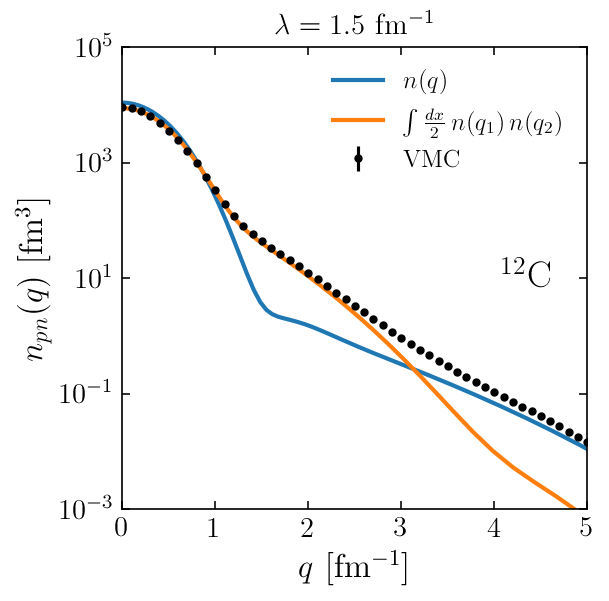

In [9]:
pair_momentum_distribution_q('C12', 'pn', 6, 1.5, x_limits=(0.0,5.0),
                             y_limits=(1e-3,1e5), show_vmc=True)

Normalization = 18.02704.


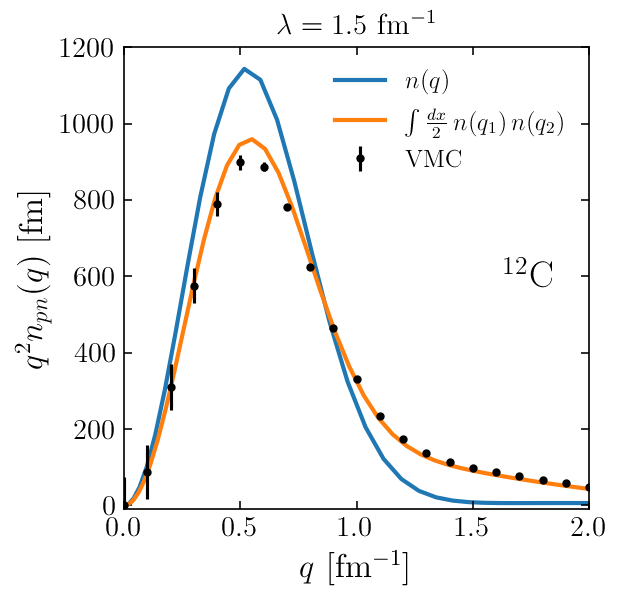

In [10]:
pair_momentum_distribution_q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,2.0), y_limits=(-10,1200),
    y_scale='linear', show_vmc=True
)

Normalization = 18.02704.


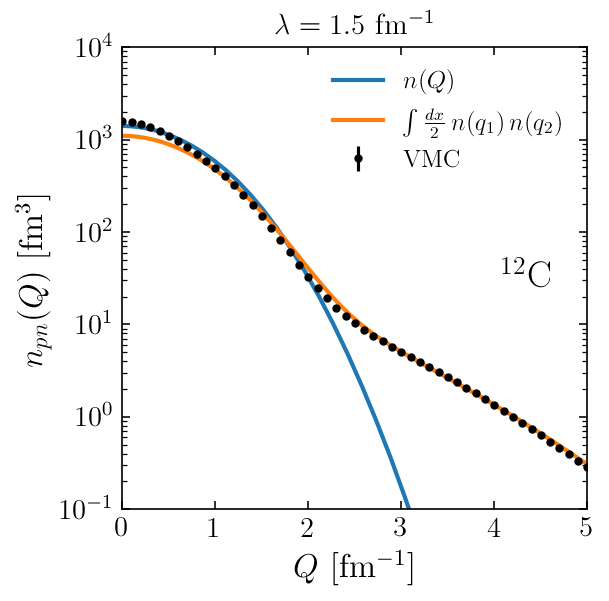

In [11]:
Q_array, n_array = pair_momentum_distribution_Q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,5.0), y_limits=(1e-1,1e4), show_vmc=True)

Normalization = 18.02704.


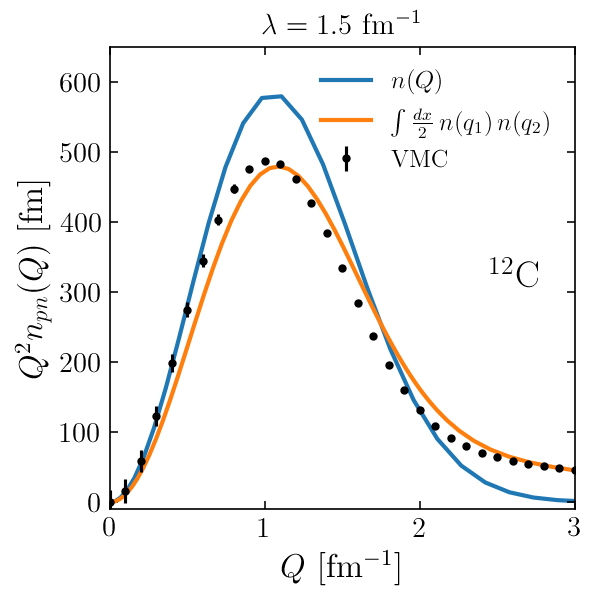

In [12]:
Q_array, n_array = pair_momentum_distribution_Q(
    'C12', 'pn', 6, 1.5, x_limits=(0.0,3.0), y_limits=(-10,650),
    y_scale='linear', show_vmc=True
)

Normalization = 1.99907.


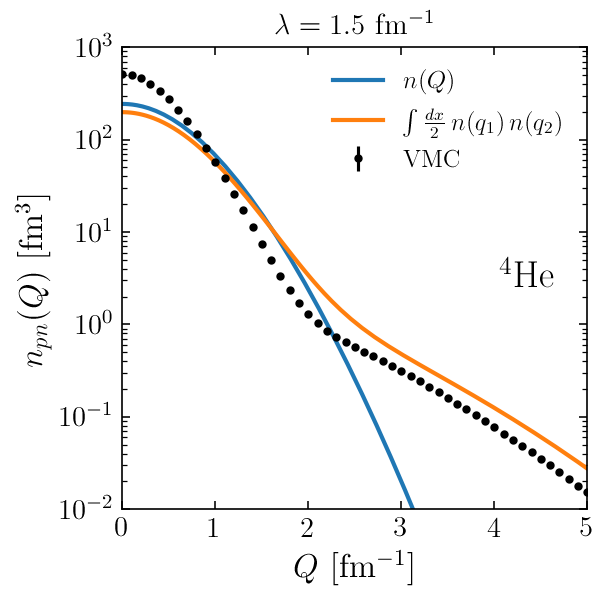

In [13]:
Q_array, n_array = pair_momentum_distribution_Q(
    'He4', 'pn', 6, 1.5, x_limits=(0.0,5.0), y_limits=(1e-2,1e3), show_vmc=True)

Normalization = 1.99907.


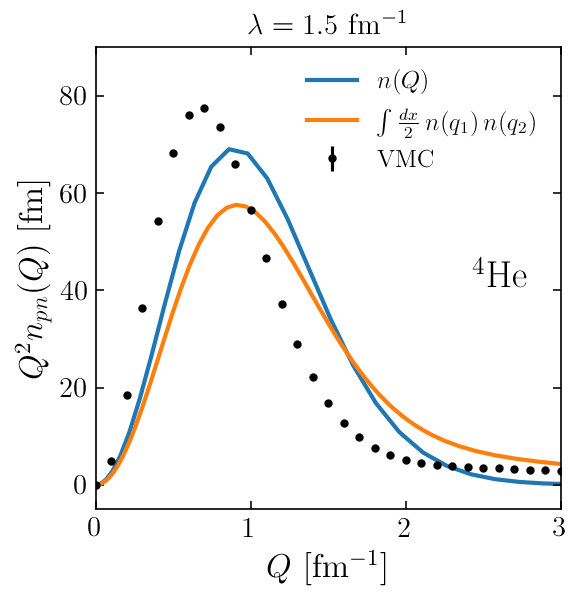

In [14]:
Q_array, n_array = pair_momentum_distribution_Q(
    'He4', 'pn', 6, 1.5, x_limits=(0.0,3.0), y_limits=(-5,90),
    y_scale='linear', show_vmc=True
)